In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
import os
import rasterio
import numpy as np
import geopandas as gpd
import pandas as pd
from rasterio.mask import mask
from shapely.geometry import Point

In [3]:
!pip install rasterio

In [4]:
import rasterio
import numpy as np
import geopandas as gpd
from rasterstats import zonal_stats
import pandas as pd

In [5]:
base_sat = "/content/drive/MyDrive/MAESTRÍA CIENCIA DE LOS DATOS Y ANALÍTICA/TRABAJO DE GRADO/DATOS/DATOS_SATELITALES/"

In [6]:
lst2023_path = base_sat + "LST_2023_Reproyectado.tif"
urb23_path   = base_sat + "urbano_UNet_2023.tif"
urb30_base_path = base_sat + "urbano_CA_Markov_2030_base.tif"
urb30_acel_path = base_sat + "urbano_CA_Markov_2030_acelerado.tif"
urb30_mit_path  = base_sat + "urbano_CA_Markov_2030_mitigacion.tif"

mpios_path = base_sat + "Municipios_ValledeAburra_32618.shp"


In [7]:

print("=== LST 2023 ===")
with rasterio.open(lst2023_path) as src:
    arr_m = src.read(1, masked=True)
    lst_meta = src.meta.copy()
    nodata_raster = src.nodata


lst2023 = arr_m.astype("float32").filled(np.nan)

print("shape:", lst2023.shape)
print("NODATA metadata:", nodata_raster)
print("min,max (ignorando NaN):", np.nanmin(lst2023), np.nanmax(lst2023))



=== LST 2023 ===
shape: (2294, 4209)
NODATA metadata: -9999.0
min,max (ignorando NaN): -21.4197 46.159683


In [8]:

def read_raster_int(path):
    with rasterio.open(path) as src:
        return src.read(1).astype(int)

urb23       = read_raster_int(urb23_path)
urb30_base  = read_raster_int(urb30_base_path)
urb30_acel  = read_raster_int(urb30_acel_path)
urb30_mit   = read_raster_int(urb30_mit_path)

print("Valores únicos urbano 2023:", np.unique(urb23))
print("Valores únicos urbano 2030 base:", np.unique(urb30_base))
print("Valores únicos urbano 2030 acel:", np.unique(urb30_acel))
print("Valores únicos urbano 2030 mit:", np.unique(urb30_mit))


Valores únicos urbano 2023: [0 1]
Valores únicos urbano 2030 base: [0 1]
Valores únicos urbano 2030 acel: [0 1]
Valores únicos urbano 2030 mit: [0 1]


In [9]:

dU_base = urb30_base - urb23
dU_acel = urb30_acel - urb23
dU_mit  = urb30_mit  - urb23

print("ΔU_base únicos:", np.unique(dU_base))
print("ΔU_acel únicos:", np.unique(dU_acel))
print("ΔU_mit únicos:", np.unique(dU_mit))


ΔU_base únicos: [0 1]
ΔU_acel únicos: [0 1]
ΔU_mit únicos: [0 1]


In [10]:

mask_urb23 = (urb23 == 1) & (~np.isnan(lst2023))

LST_urb_mean = np.nanmean(lst2023[mask_urb23])
print("Promedio LST 2023 en zonas urbanas:", LST_urb_mean)

ΔLST = LST_urb_mean - lst2023

Promedio LST 2023 en zonas urbanas: 32.997147


In [11]:

def construir_LST_futura(LST2023, dU, delta):

    LST_fut = LST2023.copy()
    mask_new_urb = (dU == 1) & (~np.isnan(LST2023))
    LST_fut[mask_new_urb] = LST2023[mask_new_urb] + delta[mask_new_urb]
    return LST_fut

lst2030_base = construir_LST_futura(lst2023, dU_base, ΔLST)
lst2030_acel = construir_LST_futura(lst2023, dU_acel, ΔLST)
lst2030_mit  = construir_LST_futura(lst2023, dU_mit,  ΔLST)

print("Rango LST2030_base:", np.nanmin(lst2030_base), np.nanmax(lst2030_base))
print("Rango LST2030_acel:", np.nanmin(lst2030_acel), np.nanmax(lst2030_acel))
print("Rango LST2030_mit:",  np.nanmin(lst2030_mit),  np.nanmax(lst2030_mit))


Rango LST2030_base: -21.4197 46.159683
Rango LST2030_acel: -21.4197 46.159683
Rango LST2030_mit: -21.4197 46.159683


In [12]:

lst_meta.update(dtype="float32", nodata=-9999.0)

def save_tif(path, array, meta):
    arr_out = array.copy()
    arr_out[np.isnan(arr_out)] = -9999.0
    with rasterio.open(path, "w", **meta) as dst:
        dst.write(arr_out.astype("float32"), 1)

out_base = base_sat + "LST_2030_base_v2.tif"
out_acel = base_sat + "LST_2030_acelerado_v2.tif"
out_mit  = base_sat + "LST_2030_mitigacion_v2.tif"

save_tif(out_base, lst2030_base, lst_meta)
save_tif(out_acel, lst2030_acel, lst_meta)
save_tif(out_mit,  lst2030_mit,  lst_meta)

print("✔ LST 2030 guardada:\n", out_base, "\n", out_acel, "\n", out_mit)


✔ LST 2030 guardada:
 /content/drive/MyDrive/MAESTRÍA CIENCIA DE LOS DATOS Y ANALÍTICA/TRABAJO DE GRADO/DATOS/DATOS_SATELITALES/LST_2030_base_v2.tif 
 /content/drive/MyDrive/MAESTRÍA CIENCIA DE LOS DATOS Y ANALÍTICA/TRABAJO DE GRADO/DATOS/DATOS_SATELITALES/LST_2030_acelerado_v2.tif 
 /content/drive/MyDrive/MAESTRÍA CIENCIA DE LOS DATOS Y ANALÍTICA/TRABAJO DE GRADO/DATOS/DATOS_SATELITALES/LST_2030_mitigacion_v2.tif


In [13]:

gdf_mpios = gpd.read_file(mpios_path)

def zonal_mean_p75(raster_path, gdf, nodata=-9999.0):
    stats = zonal_stats(
        gdf,
        raster_path,
        stats=["mean", "percentile_75"],
        nodata=nodata,
        geojson_out=False
    )
    df = pd.DataFrame(stats)
    df.columns = ["LST_mean", "LST_p75"]
    df["Municipio"] = gdf["MPIO_CNMBR"].values
    return df[["Municipio", "LST_mean", "LST_p75"]]

df_base = zonal_mean_p75(out_base, gdf_mpios)
df_acel = zonal_mean_p75(out_acel, gdf_mpios)
df_mit  = zonal_mean_p75(out_mit,  gdf_mpios)

df_base = df_base.rename(columns={"LST_mean": "LST2030_base_mean",
                                  "LST_p75":  "LST2030_base_p75"})
df_acel = df_acel.rename(columns={"LST_mean": "LST2030_acel_mean",
                                  "LST_p75":  "LST2030_acel_p75"})
df_mit  = df_mit.rename(columns={"LST_mean": "LST2030_mit_mean",
                                  "LST_p75":  "LST2030_mit_p75"})

tabla_LST2030 = (
    df_base
    .merge(df_acel, on="Municipio")
    .merge(df_mit,  on="Municipio")
    .sort_values("Municipio")
    .reset_index(drop=True)
    .round(2)
)

tabla_LST2030

,Municipio,LST2030_base_mean,LST2030_base_p75,LST2030_acel_mean,LST2030_acel_p75,LST2030_mit_mean,LST2030_mit_p75
0,BARBOSA,16.25,19.93,16.26,19.94,16.25,19.93
1,BELLO,22.31,27.13,22.34,27.22,22.29,27.06
2,CALDAS,13.49,16.21,13.53,16.22,13.45,16.21
3,COPACABANA,22.98,27.16,23.01,27.21,22.97,27.13
4,ENVIGADO,19.59,22.07,19.68,22.10,19.55,22.06
5,GIRARDOTA,18.73,23.22,18.83,23.29,18.67,23.19
6,ITAGÜÍ,22.33,27.69,22.77,28.54,22.03,27.23
7,LA ESTRELLA,6.74,15.47,7.02,15.56,6.57,15.42
8,MEDELLÍN,21.44,26.73,21.56,27.21,21.39,26.56
9,SABANETA,18.49,21.70,18.69,21.93,18.39,21.63


In [14]:
import pandas as pd

df_LST2030 = pd.DataFrame({
    "Municipio": [
        "BARBOSA", "BELLO", "CALDAS", "COPACABANA", "ENVIGADO",
        "GIRARDOTA", "ITAGÜÍ", "LA ESTRELLA", "MEDELLÍN", "SABANETA"
    ],
    "LST2030_base_mean": [16.25, 22.31, 13.49, 22.98, 19.59, 18.73, 22.33, 6.74, 21.44, 18.49],
    "LST2030_base_p75":  [19.93, 27.13, 16.21, 27.16, 22.07, 23.22, 27.69, 15.47, 26.73, 21.70],

    "LST2030_acel_mean": [16.26, 22.34, 13.53, 23.01, 19.68, 18.83, 22.77, 7.02, 21.56, 18.69],
    "LST2030_acel_p75":  [19.94, 27.22, 16.22, 27.21, 22.10, 23.29, 28.54, 15.56, 27.21, 21.93],

    "LST2030_mit_mean": [16.25, 22.29, 13.45, 22.97, 19.55, 18.67, 22.03, 6.57, 21.39, 18.39],
    "LST2030_mit_p75":  [19.93, 27.06, 16.21, 27.13, 22.06, 23.19, 27.23, 15.42, 26.56, 21.63]
})

df_LST2030


,Municipio,LST2030_base_mean,LST2030_base_p75,LST2030_acel_mean,LST2030_acel_p75,LST2030_mit_mean,LST2030_mit_p75
0,BARBOSA,16.25,19.93,16.26,19.94,16.25,19.93
1,BELLO,22.31,27.13,22.34,27.22,22.29,27.06
2,CALDAS,13.49,16.21,13.53,16.22,13.45,16.21
3,COPACABANA,22.98,27.16,23.01,27.21,22.97,27.13
4,ENVIGADO,19.59,22.07,19.68,22.10,19.55,22.06
5,GIRARDOTA,18.73,23.22,18.83,23.29,18.67,23.19
6,ITAGÜÍ,22.33,27.69,22.77,28.54,22.03,27.23
7,LA ESTRELLA,6.74,15.47,7.02,15.56,6.57,15.42
8,MEDELLÍN,21.44,26.73,21.56,27.21,21.39,26.56
9,SABANETA,18.49,21.70,18.69,21.93,18.39,21.63


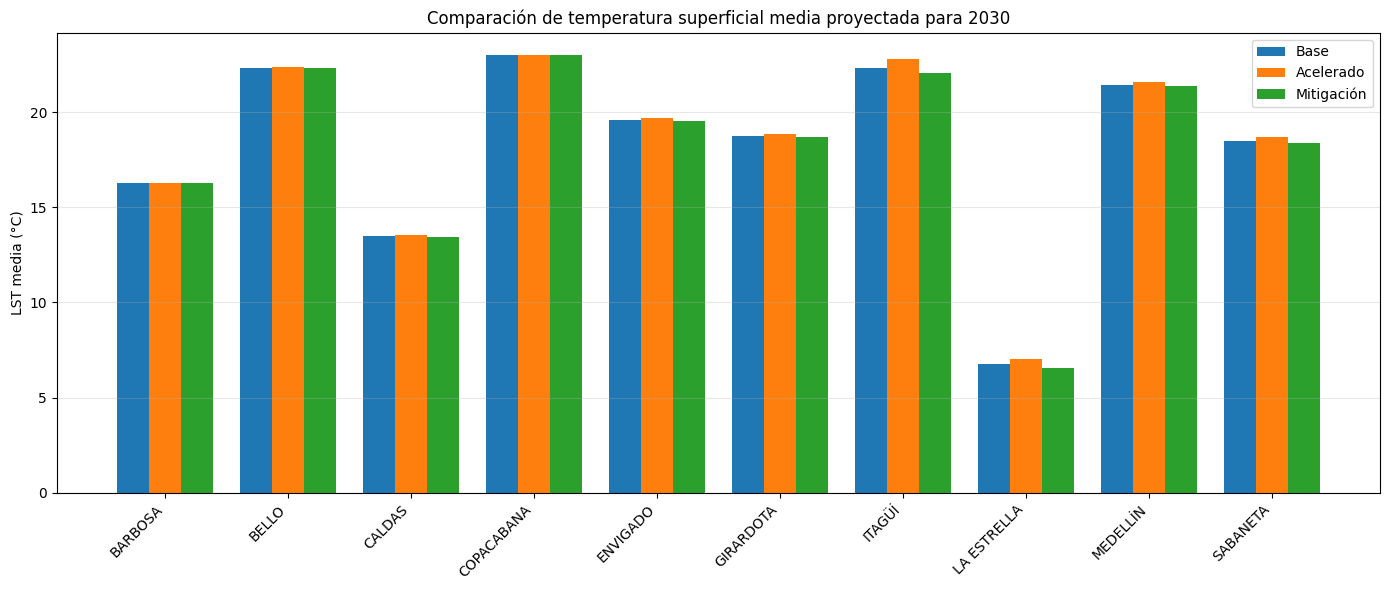

In [15]:
import matplotlib.pyplot as plt
import numpy as np

df = df_LST2030.copy()

municipios = df["Municipio"]
x = np.arange(len(municipios))
width = 0.26

plt.figure(figsize=(14,6))
plt.bar(x - width, df["LST2030_base_mean"], width, label='Base')
plt.bar(x,         df["LST2030_acel_mean"], width, label='Acelerado')
plt.bar(x + width, df["LST2030_mit_mean"], width, label='Mitigación')

plt.xticks(x, municipios, rotation=45, ha='right')
plt.ylabel("LST media (°C)")
plt.title("Comparación de temperatura superficial media proyectada para 2030")
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()


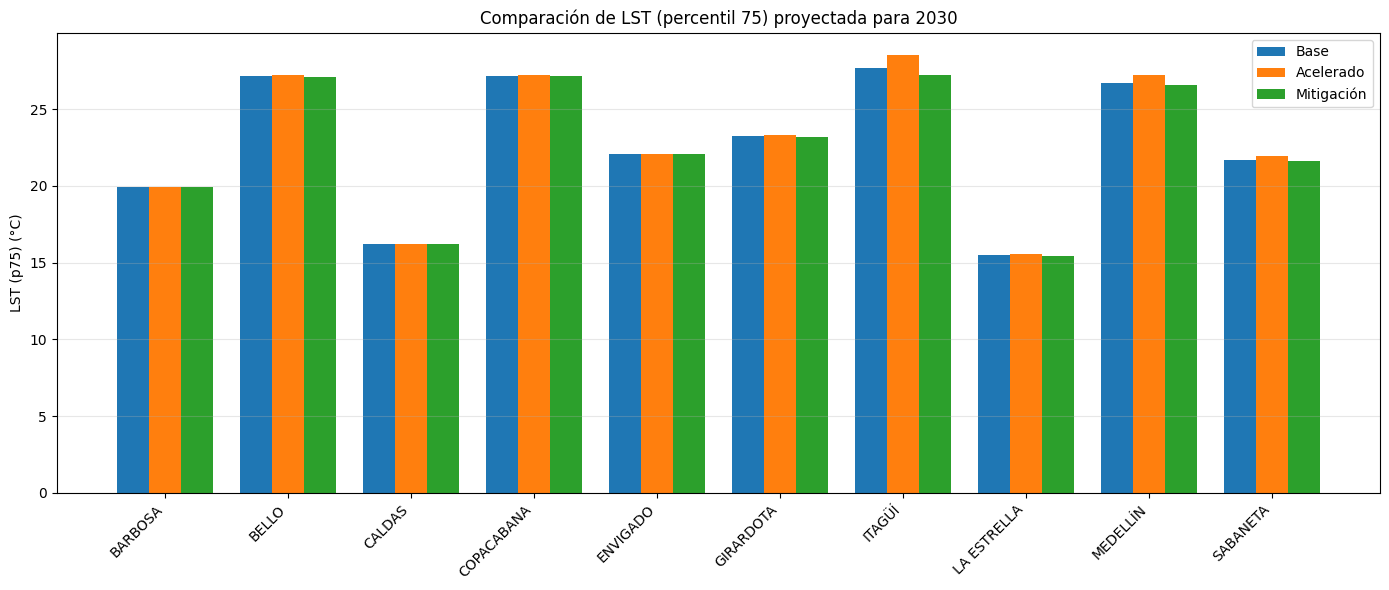

In [16]:
plt.figure(figsize=(14,6))
plt.bar(x - width, df["LST2030_base_p75"], width, label='Base')
plt.bar(x,         df["LST2030_acel_p75"], width, label='Acelerado')
plt.bar(x + width, df["LST2030_mit_p75"], width, label='Mitigación')

plt.xticks(x, municipios, rotation=45, ha='right')
plt.ylabel("LST (p75) (°C)")
plt.title("Comparación de LST (percentil 75) proyectada para 2030")
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()
